# Introduction to Machine Learning: PCAM challenge

## Setup

In order to be ready to jump in to the project, you need access to the data for the challenge and should load needed packages (and install them if colab or your computer don't have them installed.)

### Download the data

In [1]:
# download the dataset into a newly created folder called data
!wget -P data/pcam https://zenodo.org/record/7866648/files/camelyonpatch_level_2_split_test_meta.csv
!wget -P data/pcam https://zenodo.org/record/7866648/files/camelyonpatch_level_2_split_test_x.h5
!wget -P data/pcam https://zenodo.org/record/7866648/files/camelyonpatch_level_2_split_test_y.h5
!wget -P data/pcam https://zenodo.org/record/7866648/files/camelyonpatch_level_2_split_train_meta.csv
!wget -P data/pcam https://zenodo.org/record/7866648/files/camelyonpatch_level_2_split_train_x.h5
!wget -P data/pcam https://zenodo.org/record/7866648/files/camelyonpatch_level_2_split_train_y.h5
!wget -P data/pcam https://zenodo.org/record/7866648/files/camelyonpatch_level_2_split_valid_meta.csv
!wget -P data/pcam https://zenodo.org/record/7866648/files/camelyonpatch_level_2_split_valid_x.h5
!wget -P data/pcam https://zenodo.org/record/7866648/files/camelyonpatch_level_2_split_valid_y.h5

--2024-04-26 09:40:09--  https://zenodo.org/record/7866648/files/camelyonpatch_level_2_split_test_meta.csv
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.185.79.172, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/7866648/files/camelyonpatch_level_2_split_test_meta.csv [following]
--2024-04-26 09:40:09--  https://zenodo.org/records/7866648/files/camelyonpatch_level_2_split_test_meta.csv
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 80523 (79K) [text/plain]
Saving to: ‘data/pcam/camelyonpatch_level_2_split_test_meta.csv’

camelyonpatch_level 100%[===================>]  78,64K  --.-KB/s    in 0,08s   

2024-04-26 09:40:10 (987 KB/s) - ‘data/pcam/camelyonpatch_level_2_split_test_meta.csv’ saved [80523/80523]

--2024-04-26 09:40:10--  https://zenodo.org/record/7866648/files/camelyonpatch_level_2_spli

### Imports and installs

In [1]:
# you might have to change this prefix to access your data depending on what your working directory is
#import os
#print(os.getcwd())

data_prefix = 'data'

In [2]:
#!pip install torchvision
#!pip install h5py
import torch
import torchvision
import torch.nn as nn

## The data

This dataset can be troublesome to automatically download depending on Google Drive's daily download quota. It is also not the smallest (> 7GB), so we have prepared a subset that you can download. I recommend creating a project folder (on your machine or colab) and save the data in that directory under `data`.

In [4]:
#!pip install h5py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 4.8 MB/s eta 0:00:000:00:010:01


In [3]:
# Load the data splits
# this dataset requires the h5py package
pcam_data_train = torchvision.datasets.PCAM(
    root=data_prefix,
    split='train',
    download=False,
    transform=torchvision.transforms.ToTensor() # otherwise the data is a PIL image
)
pcam_data_val = torchvision.datasets.PCAM(
    root=data_prefix,
    split='val',
    download=False,
    transform=torchvision.transforms.ToTensor()
)
pcam_data_test = torchvision.datasets.PCAM(
    root=data_prefix,
    split='test',
    download=False,
    transform=torchvision.transforms.ToTensor()
)

### First time: getting to know the data

Datasets are often structured a little differently. At the beginning of a project, it helps to familiarize oneself with its structure.

In [4]:
# printing the dataset will give you information on how many samples it has, where it is stored and what transformations are applied
pcam_data_train

Dataset PCAM
    Number of datapoints: 13108
    Root location: data
    StandardTransform
Transform: ToTensor()

In [5]:
# data from pytorch is often a tuple of (data, label)

# have a look at the first sample
print("data of first sample is stored as ", type(pcam_data_train[0]), " with length ", len(pcam_data_train[0]))
print("the two elements of the tuple are data and label: ", [type(x) for x in pcam_data_train[0]])

data of first sample is stored as  <class 'tuple'>  with length  2
the two elements of the tuple are data and label:  [<class 'torch.Tensor'>, <class 'int'>]


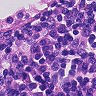

In [7]:
# if you want to visualize the data, you can convert it back to a PIL image

torchvision.transforms.ToPILImage()(pcam_data_train[0][0])

In [8]:
# what is the size of these images?

print(pcam_data_train[0][0].shape)
# this image has 3 channels (RGB) and is 96x96 pixels

# the label is binary and indicates the presence of metastatic tissue
print(pcam_data_train[0][1])

torch.Size([3, 96, 96])
0


In [9]:
# the label is binary and indicates the presence of metastatic tissue

# how many cancer samples are in the data?

all_labels = [x[1] for x in pcam_data_train]
print(sum(all_labels), ' out of ', len(all_labels), ' samples are from cancer')

6542  out of  13108  samples are from cancer


## lets get started

In [4]:
# make dataloaders
bs = 256
train_loader = torch.utils.data.DataLoader(pcam_data_train, batch_size=bs, shuffle=True)
val_loader = torch.utils.data.DataLoader(pcam_data_val, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(pcam_data_test, batch_size=bs, shuffle=True)

In [5]:
# get the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
def calc_accuracy(pred, label, bce=True):
    if bce:
        return ((pred > 0.5) == label).sum().cpu().item()
    else:
        return (pred.argmax(dim=1) == label).sum().cpu().item()

### Feed Forward

In [8]:
# build a classifier for 3x96x96 images
# use convolutional layers and attention

class FFClassifier(nn.Module):
    def __init__(self, in_size=96, in_channels=3, hidden_dims=[1024, 128], activ="relu", n_classes=1):
        super(FFClassifier, self).__init__()
        
        if activ == "silu":
            self.activation = nn.SiLU()
        else:
            self.activation = nn.ReLU()
        self.input_size = in_channels * in_size**2
        hidden_layers = len(hidden_dims)

        self.main = nn.ModuleList()
        for i in range(hidden_layers):
            if i == 0:
                self.main.append(nn.Linear(self.input_size, hidden_dims[0]))
            else:
                self.main.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
            self.main.append(self.activation)
        self.main.append(nn.Linear(hidden_dims[-1], n_classes))
        if n_classes == 1:
            self.main.append(nn.Sigmoid())
        else:
            self.main.append(nn.Softmax(-1))

    def forward(self, x):
        x = x.view(-1, self.input_size)
        for layer in self.main:
            x = layer(x)
        return x

In [14]:
###
###
# a very simple model but with rgb
###

# init model, criterion and optimizer
model = FFClassifier(hidden_dims=[1024, 128, 32], n_classes=1)
model.to(device)
criterion = nn.BCELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

n_epochs = 100

# print number of parameters in million parameters
sum(p.numel() for p in model.parameters()) / 1e6
print("Model has ", sum(p.numel() for p in model.parameters()) / 1e6, " million parameters")

train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []
for e in range(n_epochs):
    train_losses.append(0)
    train_accuracy.append(0)
    val_losses.append(0)
    val_accuracy.append(0)

    model.train()
    for x, t in train_loader:
        optimizer.zero_grad()
        x = x.to(device)
        t = t.to(device)
        y = model(x)
        loss = criterion(y.flatten(), t.float())
        loss.backward()
        optimizer.step()
        train_losses[-1] += loss.detach().cpu().item()
        train_accuracy[-1] += calc_accuracy(y.flatten(), t)
    train_losses[-1] /= len(train_loader.dataset)
    train_accuracy[-1] /= len(train_loader.dataset)

    model.eval()
    for x, t in val_loader:
        x = x.to(device)
        t = t.to(device)
        y = model(x)
        loss = criterion(y.flatten(), t.float())
        val_losses[-1] += loss.detach().cpu().item()
        val_accuracy[-1] += calc_accuracy(y.flatten(), t)
    val_losses[-1] /= len(val_loader.dataset)
    val_accuracy[-1] /= len(val_loader.dataset)

    print(f'Epoch {e+1}/{n_epochs} - train loss: {train_losses[-1]:.4f} - val loss: {val_losses[-1]:.4f} - train acc: {train_accuracy[-1]:.4f} - val acc: {val_accuracy[-1]:.4f}')

Model has  28.447937  million parameters
Epoch 1/100 - train loss: 0.6789 - val loss: 0.6302 - train acc: 0.5682 - val acc: 0.6388
Epoch 2/100 - train loss: 0.6471 - val loss: 0.6169 - train acc: 0.6023 - val acc: 0.6486
Epoch 3/100 - train loss: 0.6358 - val loss: 0.6384 - train acc: 0.6167 - val acc: 0.6382
Epoch 4/100 - train loss: 0.6327 - val loss: 0.6108 - train acc: 0.6202 - val acc: 0.6498
Epoch 5/100 - train loss: 0.6268 - val loss: 0.5938 - train acc: 0.6263 - val acc: 0.6541
Epoch 6/100 - train loss: 0.6239 - val loss: 0.6297 - train acc: 0.6320 - val acc: 0.6486
Epoch 7/100 - train loss: 0.6246 - val loss: 0.6097 - train acc: 0.6339 - val acc: 0.6510
Epoch 8/100 - train loss: 0.6155 - val loss: 0.5933 - train acc: 0.6467 - val acc: 0.6681
Epoch 9/100 - train loss: 0.6123 - val loss: 0.6022 - train acc: 0.6472 - val acc: 0.6583
Epoch 10/100 - train loss: 0.6087 - val loss: 0.5825 - train acc: 0.6546 - val acc: 0.6705
Epoch 11/100 - train loss: 0.6095 - val loss: 0.5819 - tra

In [15]:
# save model
torch.save(model.state_dict(), 'model_ff.pt')

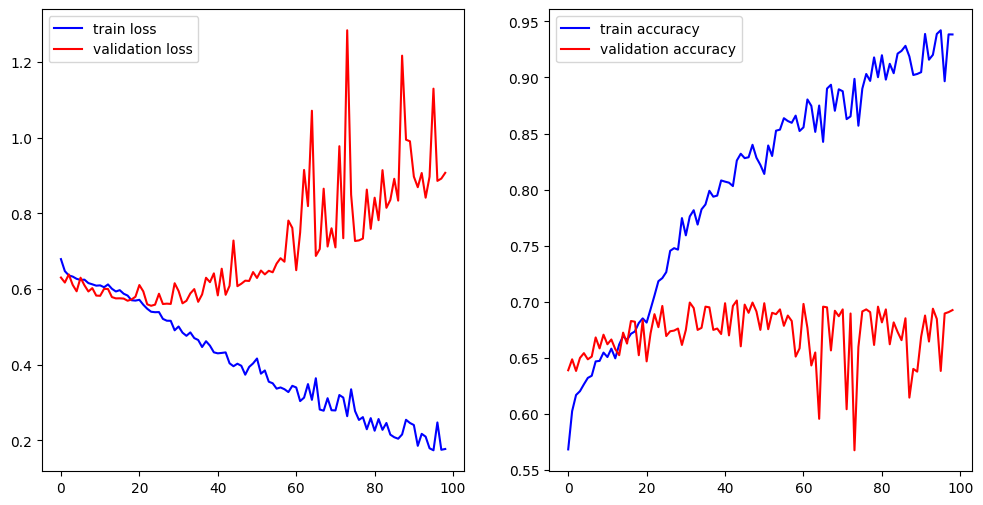

In [16]:
# plot the loss curves
import matplotlib.pyplot as plt
# make a figure with 2 subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# plot the loss curves
ax[0].plot(train_losses[:-1], label='train loss', color='blue')
ax[0].plot(val_losses[:-1], label='validation loss', color='red')
ax[0].legend()
ax[1].plot(train_accuracy[:-1], label='train accuracy', color='blue')
ax[1].plot(val_accuracy[:-1], label='validation accuracy', color='red')
ax[1].legend()
plt.show()

In [40]:
model = FFClassifier(hidden_dims=[1024, 128, 32], n_classes=1)
model.to(device)

checkpoint = torch.load('model_ff.pt')
model.load_state_dict(checkpoint)

<All keys matched successfully>

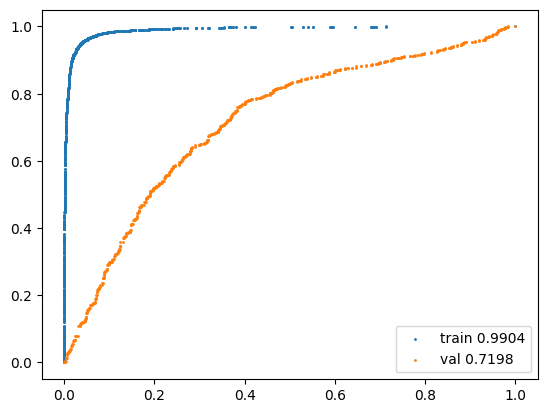

In [41]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

train_predictions = model(torch.stack([x for x, _ in train_loader.dataset]).to(device)).flatten().cpu().detach()
train_labels = np.array([t for _, t in train_loader.dataset])
fpr, tpr, thresholds = metrics.roc_curve(train_labels, train_predictions)
roc_auc = metrics.auc(fpr, tpr)

val_predictions = model(torch.stack([x for x, _ in val_loader.dataset]).to(device)).flatten().cpu().detach()
val_labels = np.array([t for _, t in val_loader.dataset])
fpr_v, tpr_v, thresholds_v = metrics.roc_curve(val_labels, val_predictions)
roc_auc_v = metrics.auc(fpr_v, tpr_v)

plt.scatter(fpr, tpr, label="train "+str(round(roc_auc,4)), s=1)
plt.scatter(fpr_v, tpr_v, label='val '+str(round(roc_auc_v,4)), s=1)
plt.legend(loc='lower right')
plt.show()

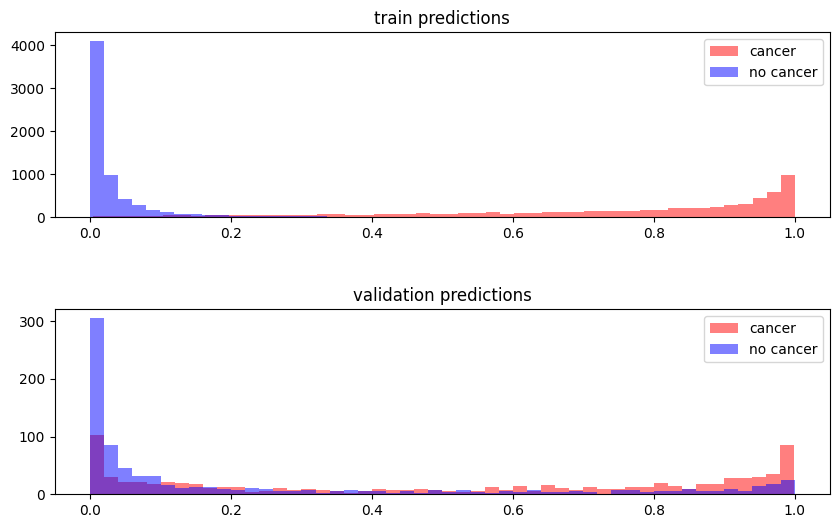

In [42]:
fig, ax = plt.subplots(2, 1, figsize=(10,6))
fig.subplots_adjust(hspace=0.5)

ax[0].hist(train_predictions[train_labels == 1].numpy(), bins=50, color='red', alpha=0.5, label='cancer')
ax[0].hist(train_predictions[train_labels == 0].numpy(), bins=50, color='blue', alpha=0.5, label='no cancer')
ax[0].legend()
ax[0].set_title("train predictions")

ax[1].hist(val_predictions[val_labels == 1].numpy(), bins=50, color='red', alpha=0.5, label='cancer')
ax[1].hist(val_predictions[val_labels == 0].numpy(), bins=50, color='blue', alpha=0.5, label='no cancer')
ax[1].legend()
ax[1].set_title("validation predictions")
plt.show()

### Conv + FF

In [8]:
# build a classifier for 3x96x96 images
# use convolutional layers and attention

from torch.nn import functional as F

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, n_embed, head_size, dropout=0.1):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x is of shape (B, T, n_embed)
        # mask is of shape (B, T, C) with 1s where there is data and 0s where there is padding
        #B,T,C = x.shape # I think this should be head_size, not n_embed, so I moved it down
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        #B,T,C = x.shape
        B,C = x.shape
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5
        # I need to mask in two steps to get only the lxl part
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size, n_embed, dropout=0.1):
        super().__init__()
        self.heads = nn.ModuleList([Head(n_embed, head_size, dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed, n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class BigClassifier(nn.Module):
    def __init__(self, capacity=8, activ="relu", skip=True, batchnorm=True, attention=True, in_channels=3, hidden_dim=128, hidden_layers=2, n_classes=2, kernel_size=4, stride=2, in_size=96, dropout=0.0):
        super(BigClassifier, self).__init__()
        
        if activ == "silu":
            self.activation = nn.SiLU()
        else:
            self.activation = nn.ReLU()
        if batchnorm:
            self.bn1 = nn.BatchNorm2d(in_channels)
            self.bn2 = nn.BatchNorm2d(capacity)
            self.bn3 = nn.BatchNorm2d(capacity*2)
            self.bn4 = nn.BatchNorm2d(capacity*4)
        else:
            self.bn1 = nn.Identity()
            self.bn2 = nn.Identity()
            self.bn3 = nn.Identity()
            self.bn4 = nn.Identity()
        self.capacity = capacity
        self.image_size = in_size
        self.skip = skip

        # like in nvae add a first 1x1 layer
        self.conv1 = nn.Conv2d(in_channels, capacity, kernel_size=1, stride=1, padding=0)
        self.conv1_1 = nn.Conv2d(capacity, capacity, kernel_size=kernel_size, stride=stride, padding=1)
        out_1 = self.output_size(in_size, kernel_size, stride, 1)
        if self.skip:
            self.conv1_2 = nn.Conv2d(capacity, capacity, kernel_size=kernel_size*2, stride=stride, padding=self.calc_padding(in_size, kernel_size*2, stride, out_1))

        # another block
        self.conv2 = nn.Conv2d(capacity, capacity*2, kernel_size=1, stride=1, padding=1)
        self.conv2_1 = nn.Conv2d(capacity*2, capacity*2, kernel_size=kernel_size, stride=stride, padding=1)
        out_2 = self.output_size(out_1, kernel_size, stride, 1)
        if self.skip:
            self.conv2_2 = nn.Conv2d(capacity*2, capacity*2, kernel_size=kernel_size*2, stride=stride, padding=self.calc_padding(out_1, kernel_size*2, stride, out_2))
        #self.conv3 = nn.Conv2d(capacity*2, capacity*4, kernel_size=1, stride=1, padding=1)
        #out_3 = self.output_size(out_2, kernel_size, stride, 1)
        #self.conv3_1 = nn.Conv2d(capacity*4, capacity*4, kernel_size=kernel_size, stride=stride, padding=1)
        
        # add attention
        #self.ff1 = nn.Linear(capacity*4*(out_3+1)**2, hidden_dim)
        self.ff1 = nn.Linear(capacity*2*(out_2+1)**2, hidden_dim)
        self.drop1 = nn.Dropout(dropout)
        if attention:
            self.attn = MultiHeadAttention(4, int(hidden_dim/4), hidden_dim, 0.1)
        else:
            self.attn = nn.Identity()

        self.ff_out = nn.ModuleList()
        for i in range(hidden_layers):
            if i == 0:
                self.ff_out.append(nn.Linear(hidden_dim, int(hidden_dim/2)))
            else:
                self.ff_out.append(nn.Linear(int(hidden_dim/2), int(hidden_dim/2)))
            self.ff_out.append(self.activation)
            self.ff_out.append(nn.Dropout(dropout))
        self.ff_out.append(nn.Linear(int(hidden_dim/2), n_classes))
        if n_classes == 1:
            self.activ_out = nn.Sigmoid()
        elif n_classes == 2:
            self.activ_out = nn.Softmax(dim=1)
        else:
            raise ValueError("Only 1 or 2 classes supported")

    def forward(self, x):
        x = self.activation(self.bn1(x))
        x = self.conv1(x)
        x = self.activation(self.bn2(x))
        x1_1 = self.conv1_1(x)
        if self.skip:
            x1_2 = self.conv1_2(x)
            y1 = x1_1 + x1_2
        else:
            y1 = x1_1
        y1 = self.activation(self.bn2(y1))
        y1 = self.conv2(y1)
        y1 = self.activation(self.bn3(y1))
        y2_1 = self.conv2_1(y1)
        if self.skip:
            y2_2 = self.conv2_2(y1)
            y2 = y2_1 + y2_2
        else:
            y2 = y2_1
        y2 = self.activation(self.bn3(y2))
        #y2 = self.conv3(y2)
        #y2 = self.activation(self.bn4(y2))
        #y2 = self.conv3_1(y2)
        #y2 = self.activation(self.bn4(y2))
        y2 = y2.view(y2.shape[0], -1)
        y2 = self.drop1(self.activation(self.ff1(y2)))
        #y2 = self.attn(y2)
        for layer in self.ff_out:
            y2 = layer(y2)
        return self.activ_out(y2)
    
    def output_size(self, w, k, s, p):
        return int(1 + ((w + 2*p - k) / s))
    
    def calc_padding(self, w, k, s, out):
        return int(0.5 * ((out - 1) * s - w + k))

In [19]:
model = BigClassifier(
    capacity=16,
    kernel_size=8,
    stride=2,
    hidden_dim=64, 
    attention=False,
    skip=False,
    batchnorm=False,
    n_classes=1
)

model.to(device)
criterion = nn.BCELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

n_epochs = 100

# print number of parameters in million parameters
sum(p.numel() for p in model.parameters()) / 1e6
print("Model has ", sum(p.numel() for p in model.parameters()) / 1e6, " million parameters")

train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []
for e in range(n_epochs):
    train_losses.append(0)
    train_accuracy.append(0)
    val_losses.append(0)
    val_accuracy.append(0)

    model.train()
    for x, t in train_loader:
        optimizer.zero_grad()
        x = x.to(device)
        t = t.to(device)
        y = model(x)
        loss = criterion(y.flatten(), t.float())
        loss.backward()
        optimizer.step()
        train_losses[-1] += loss.detach().cpu().item()
        train_accuracy[-1] += calc_accuracy(y.flatten(), t)
    train_losses[-1] /= len(train_loader.dataset)
    train_accuracy[-1] /= len(train_loader.dataset)

    model.eval()
    for x, t in val_loader:
        x = x.to(device)
        t = t.to(device)
        y = model(x)
        loss = criterion(y.flatten(), t.float())
        val_losses[-1] += loss.detach().cpu().item()
        val_accuracy[-1] += calc_accuracy(y.flatten(), t)
    val_losses[-1] /= len(val_loader.dataset)
    val_accuracy[-1] /= len(val_loader.dataset)

    print(f'Epoch {e+1}/{n_epochs} - train loss: {train_losses[-1]:.4f} - val loss: {val_losses[-1]:.4f} - train acc: {train_accuracy[-1]:.4f} - val acc: {val_accuracy[-1]:.4f}')

Model has  1.077041  million parameters
Epoch 1/100 - train loss: 0.6835 - val loss: 0.6357 - train acc: 0.5765 - val acc: 0.6711
Epoch 2/100 - train loss: 0.5808 - val loss: 0.5209 - train acc: 0.7114 - val acc: 0.7383
Epoch 3/100 - train loss: 0.5265 - val loss: 0.5149 - train acc: 0.7476 - val acc: 0.7383
Epoch 4/100 - train loss: 0.5171 - val loss: 0.5110 - train acc: 0.7556 - val acc: 0.7431
Epoch 5/100 - train loss: 0.5064 - val loss: 0.5474 - train acc: 0.7614 - val acc: 0.7297
Epoch 6/100 - train loss: 0.5040 - val loss: 0.5009 - train acc: 0.7627 - val acc: 0.7444
Epoch 7/100 - train loss: 0.4878 - val loss: 0.5536 - train acc: 0.7723 - val acc: 0.7358
Epoch 8/100 - train loss: 0.4800 - val loss: 0.5238 - train acc: 0.7759 - val acc: 0.7401
Epoch 9/100 - train loss: 0.4829 - val loss: 0.5093 - train acc: 0.7725 - val acc: 0.7358
Epoch 10/100 - train loss: 0.4742 - val loss: 0.4904 - train acc: 0.7803 - val acc: 0.7566
Epoch 11/100 - train loss: 0.4633 - val loss: 0.5007 - trai

In [20]:
# save model
torch.save(model.state_dict(), 'model_conv1.pt')

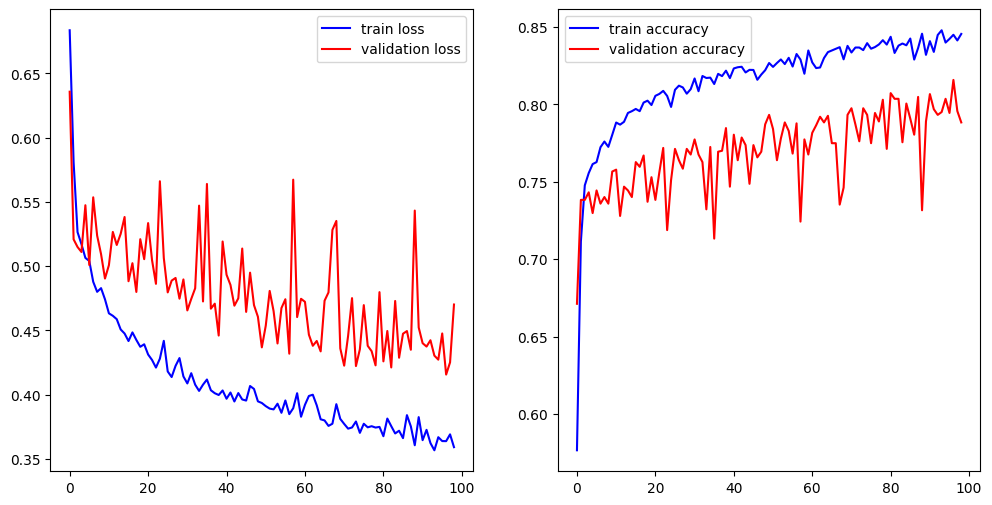

In [21]:
# plot the loss curves
import matplotlib.pyplot as plt
# make a figure with 2 subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# plot the loss curves
ax[0].plot(train_losses[:-1], label='train loss', color='blue')
ax[0].plot(val_losses[:-1], label='validation loss', color='red')
ax[0].legend()
ax[1].plot(train_accuracy[:-1], label='train accuracy', color='blue')
ax[1].plot(val_accuracy[:-1], label='validation accuracy', color='red')
ax[1].legend()
plt.show()

In [20]:
model = BigClassifier(
    capacity=16,
    kernel_size=8,
    stride=2,
    hidden_dim=64, 
    attention=False,
    skip=False,
    batchnorm=False,
    n_classes=1
)
model.to(device)

checkpoint = torch.load('model_conv1.pt')
model.load_state_dict(checkpoint)

<All keys matched successfully>

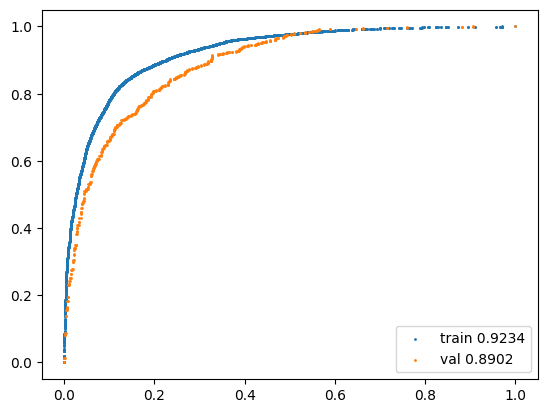

In [35]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

train_predictions = model(torch.stack([x for x, _ in train_loader.dataset]).to(device)).flatten().cpu().detach()
train_labels = np.array([t for _, t in train_loader.dataset])
fpr, tpr, thresholds = metrics.roc_curve(train_labels, train_predictions)
roc_auc = metrics.auc(fpr, tpr)

val_predictions = model(torch.stack([x for x, _ in val_loader.dataset]).to(device)).flatten().cpu().detach()
val_labels = np.array([t for _, t in val_loader.dataset])
fpr_v, tpr_v, thresholds_v = metrics.roc_curve(val_labels, val_predictions)
roc_auc_v = metrics.auc(fpr_v, tpr_v)

plt.scatter(fpr, tpr, label="train "+str(round(roc_auc,4)), s=1)
plt.scatter(fpr_v, tpr_v, label='val '+str(round(roc_auc_v,4)), s=1)
plt.legend(loc='lower right')
plt.show()

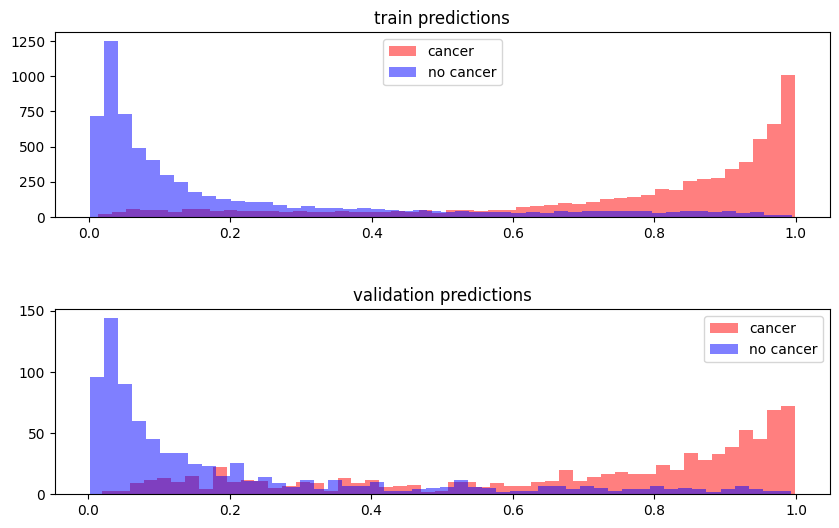

In [39]:
fig, ax = plt.subplots(2, 1, figsize=(10,6))
fig.subplots_adjust(hspace=0.5)

ax[0].hist(train_predictions[train_labels == 1].numpy(), bins=50, color='red', alpha=0.5, label='cancer')
ax[0].hist(train_predictions[train_labels == 0].numpy(), bins=50, color='blue', alpha=0.5, label='no cancer')
ax[0].legend()
ax[0].set_title("train predictions")

ax[1].hist(val_predictions[val_labels == 1].numpy(), bins=50, color='red', alpha=0.5, label='cancer')
ax[1].hist(val_predictions[val_labels == 0].numpy(), bins=50, color='blue', alpha=0.5, label='no cancer')
ax[1].legend()
ax[1].set_title("validation predictions")
plt.show()

### Conv + FF (ResNetIsh)

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ResidualBlock, self).__init__()
        self.main = nn.ModuleList()
        self.main.append(nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=kernel_size, stride=stride, padding=padding))
        self.main.append(nn.ReLU())
        self.main.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding))
        self.main.append(nn.ReLU())

    def forward(self, x):
        for layer in self.main:
            x = layer(x)
        return x

class ResNetIsh(nn.Module):
    def __init__(self, in_channels, hidden_dim=32, hidden_layers=4, layer_size=3, n_classes=1, drop=0.1):
        super(ResNetIsh, self).__init__()
        self.in_channels = in_channels
        self.hidden_dim = hidden_dim
        self.hidden_layers = hidden_layers
        self.n_classes = n_classes

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=hidden_dim, kernel_size=7, stride=2)
        self.pool1 = nn.MaxPool2d(2, 2)
        #self.main.append(nn.ReLU())
        self.main = nn.ModuleList()
        for i in range(hidden_layers):
            for j in range(layer_size):
                if j == layer_size - 1:
                    self.main.append(ResidualBlock((i+1)*(hidden_dim), (i+2)*(hidden_dim), padding=0))
                else:
                    self.main.append(ResidualBlock((i+1)*(hidden_dim), (i+1)*(hidden_dim)))
        #self.main.append(nn.AvgPool2d(2, 2))
        self.fc = nn.ModuleList()
        self.fc.append(nn.Flatten())
        self.fc.append(nn.Linear(5760, 128))
        self.fc.append(nn.ReLU())
        self.fc.append(nn.Dropout(drop))
        self.fc.append(nn.Linear(128, n_classes))
        self.fc.append(nn.Sigmoid())

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        for layer in self.main:
            x2 = layer(x)
            if (x.shape[1] == x2.shape[1]) & (x.shape[-1] == x2.shape[-1]):
                x = x + x2
            else:
                x = x2
        for fc_layer in self.fc:
            x = fc_layer(x)
        return x

In [8]:
model = ResNetIsh(
    in_channels=3,
    hidden_dim=32,
    hidden_layers=4,
    layer_size=3,
    n_classes=1,
    drop=0.1
)

model.to(device)
criterion = nn.BCELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

n_epochs = 100

# print number of parameters in million parameters
sum(p.numel() for p in model.parameters()) / 1e6
print("Model has ", sum(p.numel() for p in model.parameters()) / 1e6, " million parameters")

train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []
for e in range(n_epochs):
    train_losses.append(0)
    train_accuracy.append(0)
    val_losses.append(0)
    val_accuracy.append(0)

    model.train()
    for x, t in train_loader:
        optimizer.zero_grad()
        x = x.to(device)
        t = t.to(device)
        y = model(x)
        loss = criterion(y.flatten(), t.float())
        loss.backward()
        optimizer.step()
        train_losses[-1] += loss.detach().cpu().item()
        train_accuracy[-1] += calc_accuracy(y.flatten(), t)
    train_losses[-1] /= len(train_loader.dataset)
    train_accuracy[-1] /= len(train_loader.dataset)

    model.eval()
    for x, t in val_loader:
        x = x.to(device)
        t = t.to(device)
        y = model(x)
        loss = criterion(y.flatten(), t.float())
        val_losses[-1] += loss.detach().cpu().item()
        val_accuracy[-1] += calc_accuracy(y.flatten(), t)
    val_losses[-1] /= len(val_loader.dataset)
    val_accuracy[-1] /= len(val_loader.dataset)

    print(f'Epoch {e+1}/{n_epochs} - train loss: {train_losses[-1]:.4f} - val loss: {val_losses[-1]:.4f} - train acc: {train_accuracy[-1]:.4f} - val acc: {val_accuracy[-1]:.4f}')

Model has  2.495361  million parameters
Epoch 1/100 - train loss: 0.6670 - val loss: 0.8470 - train acc: 0.5933 - val acc: 0.5906
Epoch 2/100 - train loss: 0.5489 - val loss: 0.5070 - train acc: 0.7429 - val acc: 0.7535
Epoch 3/100 - train loss: 0.5063 - val loss: 0.4929 - train acc: 0.7650 - val acc: 0.7602
Epoch 4/100 - train loss: 0.4929 - val loss: 0.5150 - train acc: 0.7730 - val acc: 0.7376
Epoch 5/100 - train loss: 0.4901 - val loss: 0.5124 - train acc: 0.7735 - val acc: 0.7529
Epoch 6/100 - train loss: 0.4914 - val loss: 0.5445 - train acc: 0.7724 - val acc: 0.7297
Epoch 7/100 - train loss: 0.4847 - val loss: 0.4695 - train acc: 0.7766 - val acc: 0.7645
Epoch 8/100 - train loss: 0.4819 - val loss: 0.4960 - train acc: 0.7761 - val acc: 0.7645
Epoch 9/100 - train loss: 0.4755 - val loss: 0.5221 - train acc: 0.7819 - val acc: 0.7340
Epoch 10/100 - train loss: 0.4780 - val loss: 0.4628 - train acc: 0.7770 - val acc: 0.7639
Epoch 11/100 - train loss: 0.4482 - val loss: 0.4547 - trai

KeyboardInterrupt: 

In [9]:
# save model
torch.save(model.state_dict(), 'model_conv2.pt')

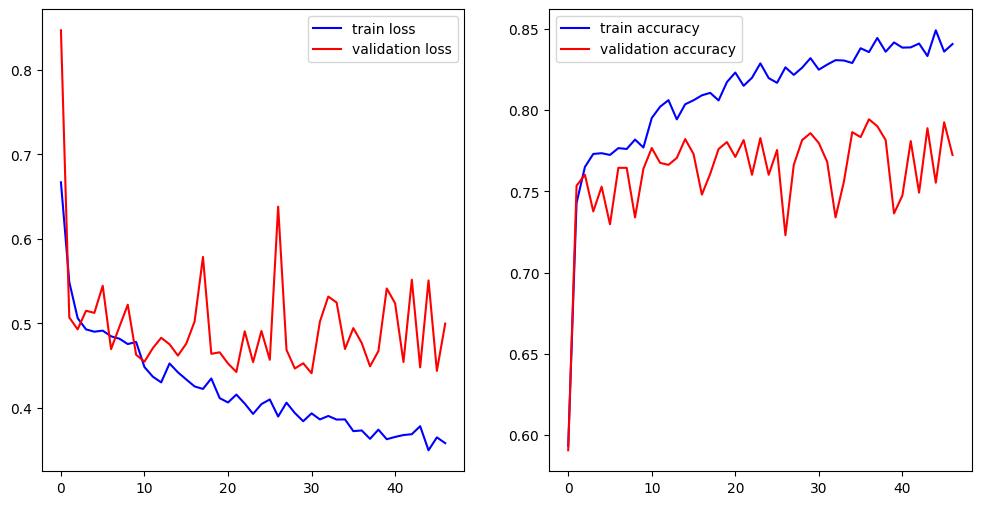

In [10]:
# plot the loss curves
import matplotlib.pyplot as plt
# make a figure with 2 subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# plot the loss curves
ax[0].plot(train_losses[:-1], label='train loss', color='blue')
ax[0].plot(val_losses[:-1], label='validation loss', color='red')
ax[0].legend()
ax[1].plot(train_accuracy[:-1], label='train accuracy', color='blue')
ax[1].plot(val_accuracy[:-1], label='validation accuracy', color='red')
ax[1].legend()
plt.show()

In [7]:
# use cpu because not enough memory on GPU
device = 'cpu'

model = ResNetIsh(
    in_channels=3,
    hidden_dim=32,
    hidden_layers=4,
    layer_size=3,
    n_classes=1,
    drop=0.1
)

checkpoint = torch.load('model_conv2.pt', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)

<All keys matched successfully>

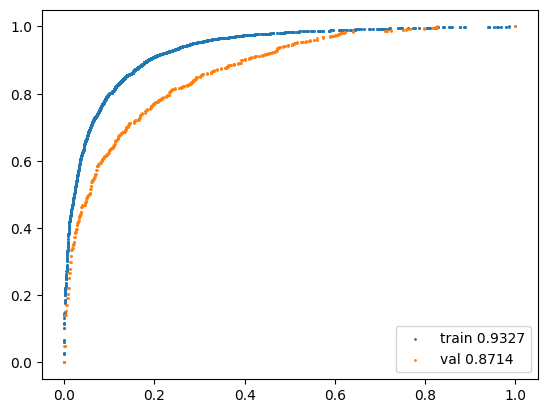

In [8]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

train_predictions = model(torch.stack([x for x, _ in train_loader.dataset]).to(device)).flatten().cpu().detach()
train_labels = np.array([t for _, t in train_loader.dataset])
fpr, tpr, thresholds = metrics.roc_curve(train_labels, train_predictions)
roc_auc = metrics.auc(fpr, tpr)

val_predictions = model(torch.stack([x for x, _ in val_loader.dataset]).to(device)).flatten().cpu().detach()
val_labels = np.array([t for _, t in val_loader.dataset])
fpr_v, tpr_v, thresholds_v = metrics.roc_curve(val_labels, val_predictions)
roc_auc_v = metrics.auc(fpr_v, tpr_v)

plt.scatter(fpr, tpr, label="train "+str(round(roc_auc,4)), s=1)
plt.scatter(fpr_v, tpr_v, label='val '+str(round(roc_auc_v,4)), s=1)
plt.legend(loc='lower right')
plt.show()

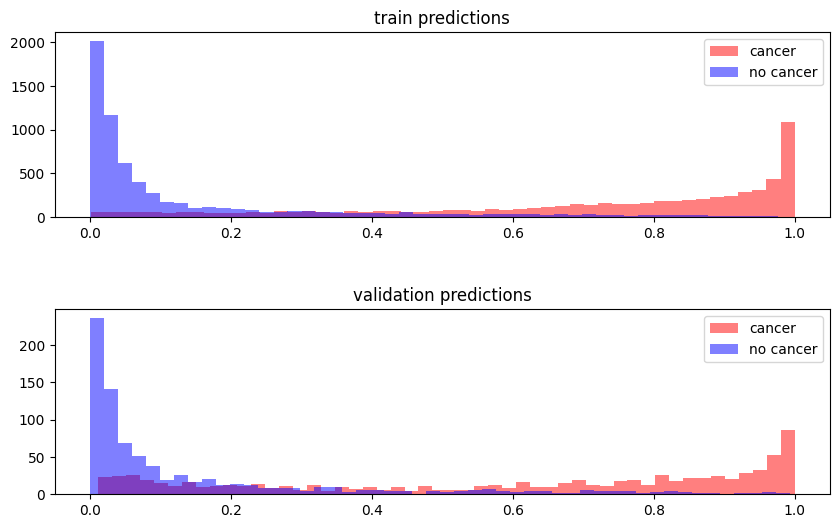

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(10,6))
fig.subplots_adjust(hspace=0.5)

ax[0].hist(train_predictions[train_labels == 1].numpy(), bins=50, color='red', alpha=0.5, label='cancer')
ax[0].hist(train_predictions[train_labels == 0].numpy(), bins=50, color='blue', alpha=0.5, label='no cancer')
ax[0].legend()
ax[0].set_title("train predictions")

ax[1].hist(val_predictions[val_labels == 1].numpy(), bins=50, color='red', alpha=0.5, label='cancer')
ax[1].hist(val_predictions[val_labels == 0].numpy(), bins=50, color='blue', alpha=0.5, label='no cancer')
ax[1].legend()
ax[1].set_title("validation predictions")
plt.show()

### ResNet18

In [8]:
import torch.nn.functional as F

In [10]:
# now try resnet50 as a model
model = torchvision.models.resnet18(pretrained=True)
for params in model.parameters():
  params.requires_grad_ = False
model.fc = nn.Linear(model.fc.in_features, 1)
model.to(device)
criterion = nn.BCEWithLogitsLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

n_epochs = 100

# print number of parameters in million parameters
sum(p.numel() for p in model.parameters()) / 1e6
print("Model has ", sum(p.numel() for p in model.parameters()) / 1e6, " million parameters")

train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []
for e in range(n_epochs):
    train_losses.append(0)
    train_accuracy.append(0)
    val_losses.append(0)
    val_accuracy.append(0)

    model.train()
    for x, t in train_loader:
        optimizer.zero_grad()
        x = x.to(device)
        t = t.to(device)
        y = F.sigmoid(model(x))
        loss = criterion(y.flatten(), t.float())
        loss.backward()
        optimizer.step()
        train_losses[-1] += loss.detach().cpu().item()
        #train_accuracy[-1] += ((y.argmax(dim=1) == t).sum().cpu().item())
        train_accuracy[-1] += calc_accuracy(y.flatten(), t)
    train_losses[-1] /= len(train_loader.dataset)
    train_accuracy[-1] /= len(train_loader.dataset)

    model.eval()
    for x, t in val_loader:
        x = x.to(device)
        t = t.to(device)
        y = F.sigmoid(model(x))
        loss = criterion(y.flatten(), t.float())
        val_losses[-1] += loss.detach().cpu().item()
        #val_accuracy[-1] += ((y.argmax(dim=1) == t).sum().cpu().item())
        val_accuracy[-1] += calc_accuracy(y.flatten(), t)
    val_losses[-1] /= len(val_loader.dataset)
    val_accuracy[-1] /= len(val_loader.dataset)

    print(f'Epoch {e+1}/{n_epochs} - train loss: {train_losses[-1]:.4f} - val loss: {val_losses[-1]:.4f} - train acc: {train_accuracy[-1]:.4f} - val acc: {val_accuracy[-1]:.4f}')

Model has  11.177025  million parameters
Epoch 1/100 - train loss: 0.5839 - val loss: 0.5859 - train acc: 0.8168 - val acc: 0.7895
Epoch 2/100 - train loss: 0.5397 - val loss: 0.5711 - train acc: 0.9190 - val acc: 0.8408
Epoch 3/100 - train loss: 0.5248 - val loss: 0.5703 - train acc: 0.9522 - val acc: 0.8426
Epoch 4/100 - train loss: 0.5192 - val loss: 0.5715 - train acc: 0.9654 - val acc: 0.8377
Epoch 5/100 - train loss: 0.5146 - val loss: 0.5686 - train acc: 0.9747 - val acc: 0.8493
Epoch 6/100 - train loss: 0.5120 - val loss: 0.5713 - train acc: 0.9809 - val acc: 0.8377
Epoch 7/100 - train loss: 0.5112 - val loss: 0.5773 - train acc: 0.9824 - val acc: 0.8231
Epoch 8/100 - train loss: 0.5107 - val loss: 0.5714 - train acc: 0.9835 - val acc: 0.8347
Epoch 9/100 - train loss: 0.5098 - val loss: 0.5739 - train acc: 0.9852 - val acc: 0.8261
Epoch 10/100 - train loss: 0.5098 - val loss: 0.5738 - train acc: 0.9854 - val acc: 0.8267
Epoch 11/100 - train loss: 0.5094 - val loss: 0.5742 - tra

KeyboardInterrupt: 

In [11]:
# save model
torch.save(model.state_dict(), 'model_resnet18.pt')

In [7]:
# use cpu because not enough memory on GPU
device = 'cpu'

model = torchvision.models.resnet18(pretrained=True)
for params in model.parameters():
  params.requires_grad_ = False
model.fc = nn.Linear(model.fc.in_features, 1)

checkpoint = torch.load('model_resnet18.pt', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)

/home/dbm829/.conda/envs/image_dgd_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dbm829/.conda/envs/image_dgd_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

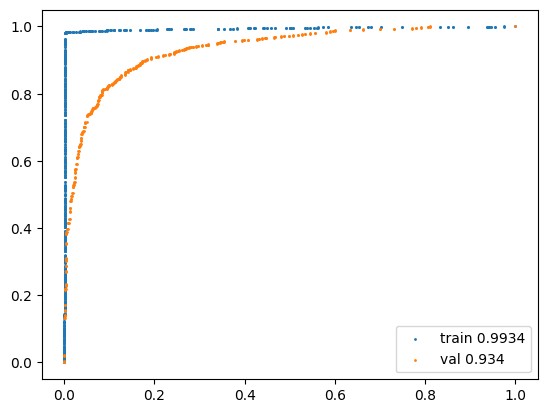

In [8]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

train_predictions = model(torch.stack([x for x, _ in train_loader.dataset]).to(device)).flatten().cpu().detach()
train_labels = np.array([t for _, t in train_loader.dataset])
fpr, tpr, thresholds = metrics.roc_curve(train_labels, train_predictions)
roc_auc = metrics.auc(fpr, tpr)

val_predictions = model(torch.stack([x for x, _ in val_loader.dataset]).to(device)).flatten().cpu().detach()
val_labels = np.array([t for _, t in val_loader.dataset])
fpr_v, tpr_v, thresholds_v = metrics.roc_curve(val_labels, val_predictions)
roc_auc_v = metrics.auc(fpr_v, tpr_v)

plt.scatter(fpr, tpr, label="train "+str(round(roc_auc,4)), s=1)
plt.scatter(fpr_v, tpr_v, label='val '+str(round(roc_auc_v,4)), s=1)
plt.legend(loc='lower right')
plt.show()

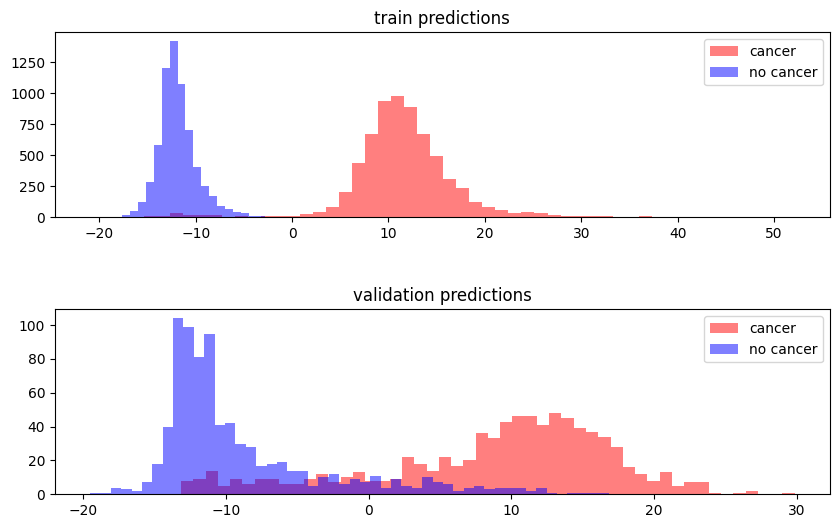

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(10,6))
fig.subplots_adjust(hspace=0.5)

ax[0].hist(train_predictions[train_labels == 1].numpy(), bins=50, color='red', alpha=0.5, label='cancer')
ax[0].hist(train_predictions[train_labels == 0].numpy(), bins=50, color='blue', alpha=0.5, label='no cancer')
ax[0].legend()
ax[0].set_title("train predictions")

ax[1].hist(val_predictions[val_labels == 1].numpy(), bins=50, color='red', alpha=0.5, label='cancer')
ax[1].hist(val_predictions[val_labels == 0].numpy(), bins=50, color='blue', alpha=0.5, label='no cancer')
ax[1].legend()
ax[1].set_title("validation predictions")
plt.show()

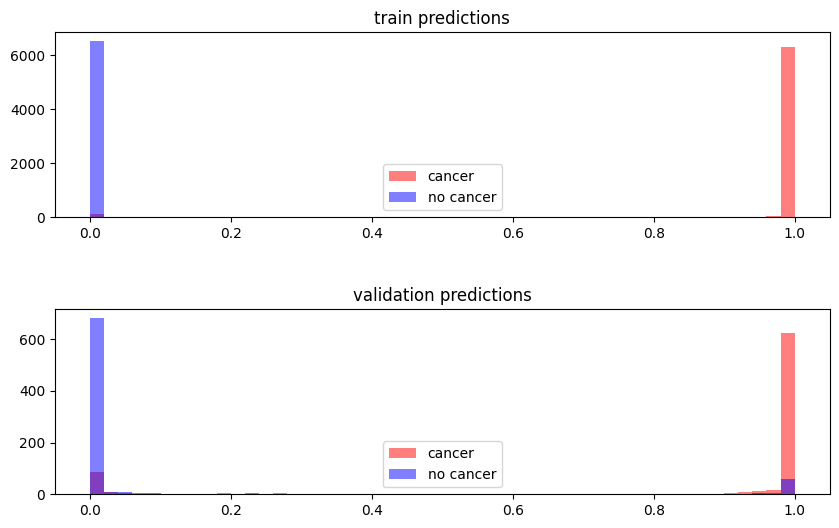

In [10]:
# put predictions through a sigmoid
t_pred_sig = F.sigmoid(train_predictions)
v_pred_sig = F.sigmoid(val_predictions)

fig, ax = plt.subplots(2, 1, figsize=(10,6))
fig.subplots_adjust(hspace=0.5)

ax[0].hist(t_pred_sig[train_labels == 1].numpy(), bins=50, color='red', alpha=0.5, label='cancer')
ax[0].hist(t_pred_sig[train_labels == 0].numpy(), bins=50, color='blue', alpha=0.5, label='no cancer')
ax[0].legend()
ax[0].set_title("train predictions")

ax[1].hist(v_pred_sig[val_labels == 1].numpy(), bins=50, color='red', alpha=0.5, label='cancer')
ax[1].hist(v_pred_sig[val_labels == 0].numpy(), bins=50, color='blue', alpha=0.5, label='no cancer')
ax[1].legend()
ax[1].set_title("validation predictions")
plt.show()

In [11]:
# now try resnet50 as a model
model = torchvision.models.resnet18(pretrained=True)
for params in model.parameters():
  params.requires_grad_ = False
model.fc = nn.Sequential(
  nn.Linear(model.fc.in_features, 1),
  nn.Dropout(0.1)
)
model.to(device)
criterion = nn.BCEWithLogitsLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

n_epochs = 100

# print number of parameters in million parameters
sum(p.numel() for p in model.parameters()) / 1e6
print("Model has ", sum(p.numel() for p in model.parameters()) / 1e6, " million parameters")

train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []
for e in range(n_epochs):
    train_losses.append(0)
    train_accuracy.append(0)
    val_losses.append(0)
    val_accuracy.append(0)

    model.train()
    for x, t in train_loader:
        optimizer.zero_grad()
        x = x.to(device)
        t = t.to(device)
        y = model(x)
        loss = criterion(y.flatten(), t.float())
        loss.backward()
        optimizer.step()
        train_losses[-1] += loss.detach().cpu().item()
        #train_accuracy[-1] += ((y.argmax(dim=1) == t).sum().cpu().item())
        train_accuracy[-1] += calc_accuracy(F.sigmoid(y.flatten()), t)
    train_losses[-1] /= len(train_loader.dataset)
    train_accuracy[-1] /= len(train_loader.dataset)

    model.eval()
    for x, t in val_loader:
        x = x.to(device)
        t = t.to(device)
        y = model(x)
        loss = criterion(y.flatten(), t.float())
        val_losses[-1] += loss.detach().cpu().item()
        #val_accuracy[-1] += ((y.argmax(dim=1) == t).sum().cpu().item())
        val_accuracy[-1] += calc_accuracy(F.sigmoid(y.flatten()), t)
    val_losses[-1] /= len(val_loader.dataset)
    val_accuracy[-1] /= len(val_loader.dataset)

    print(f'Epoch {e+1}/{n_epochs} - train loss: {train_losses[-1]:.4f} - val loss: {val_losses[-1]:.4f} - train acc: {train_accuracy[-1]:.4f} - val acc: {val_accuracy[-1]:.4f}')

/home/dbm829/.conda/envs/image_dgd_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dbm829/.conda/envs/image_dgd_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model has  11.177025  million parameters
Epoch 1/100 - train loss: 0.4018 - val loss: 0.3557 - train acc: 0.8012 - val acc: 0.8334
Epoch 2/100 - train loss: 0.1964 - val loss: 0.3933 - train acc: 0.9044 - val acc: 0.8389
Epoch 3/100 - train loss: 0.1097 - val loss: 0.4901 - train acc: 0.9398 - val acc: 0.8353
Epoch 4/100 - train loss: 0.0830 - val loss: 0.5285 - train acc: 0.9491 - val acc: 0.8322
Epoch 5/100 - train loss: 0.0729 - val loss: 0.5383 - train acc: 0.9500 - val acc: 0.8487
Epoch 6/100 - train loss: 0.0733 - val loss: 0.5504 - train acc: 0.9493 - val acc: 0.8450
Epoch 7/100 - train loss: 0.0706 - val loss: 0.6304 - train acc: 0.9511 - val acc: 0.8414


KeyboardInterrupt: 

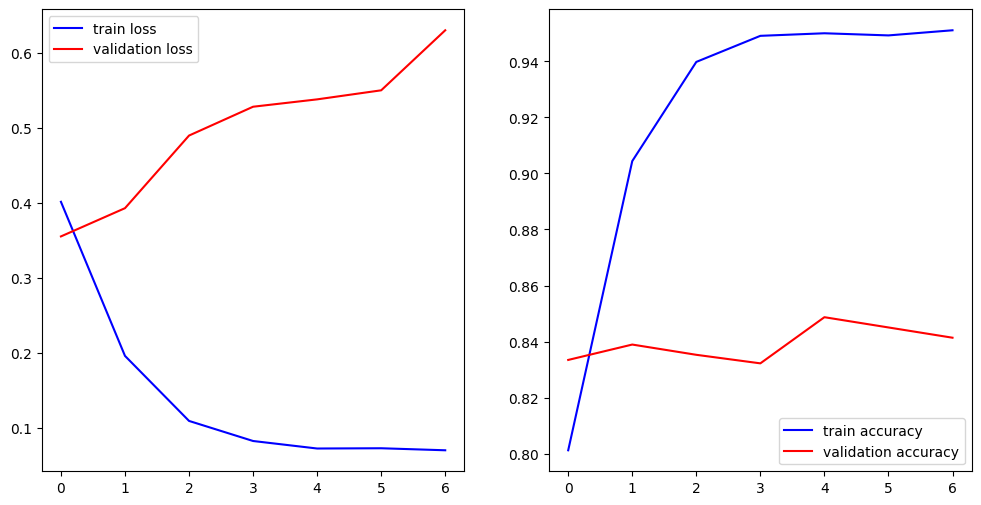

In [12]:
# plot the loss curves
import matplotlib.pyplot as plt
# make a figure with 2 subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# plot the loss curves
ax[0].plot(train_losses[:-1], label='train loss', color='blue')
ax[0].plot(val_losses[:-1], label='validation loss', color='red')
ax[0].legend()
ax[1].plot(train_accuracy[:-1], label='train accuracy', color='blue')
ax[1].plot(val_accuracy[:-1], label='validation accuracy', color='red')
ax[1].legend()
plt.show()

In [13]:
# save model
torch.save(model.state_dict(), 'model_resnet18_reg.pt')

In [14]:
torch.cuda.empty_cache()

In [16]:
device = 'cpu'
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

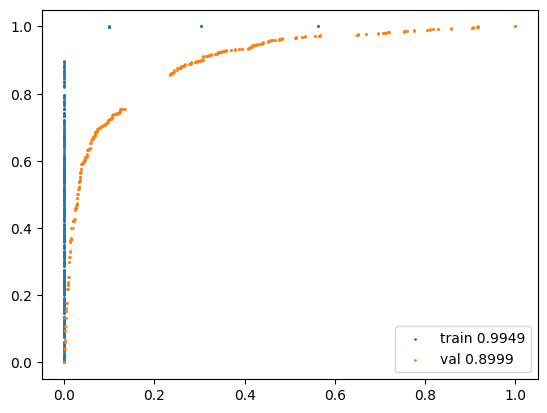

In [17]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

train_predictions = model(torch.stack([x for x, _ in train_loader.dataset]).to(device)).flatten().cpu().detach()
train_labels = np.array([t for _, t in train_loader.dataset])
fpr, tpr, thresholds = metrics.roc_curve(train_labels, train_predictions)
roc_auc = metrics.auc(fpr, tpr)

val_predictions = model(torch.stack([x for x, _ in val_loader.dataset]).to(device)).flatten().cpu().detach()
val_labels = np.array([t for _, t in val_loader.dataset])
fpr_v, tpr_v, thresholds_v = metrics.roc_curve(val_labels, val_predictions)
roc_auc_v = metrics.auc(fpr_v, tpr_v)

plt.scatter(fpr, tpr, label="train "+str(round(roc_auc,4)), s=1)
plt.scatter(fpr_v, tpr_v, label='val '+str(round(roc_auc_v,4)), s=1)
plt.legend(loc='lower right')
plt.show()

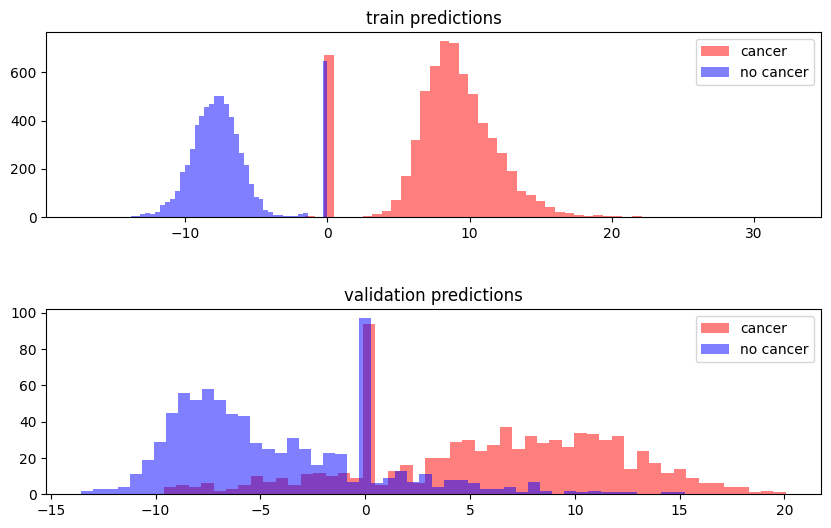

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(10,6))
fig.subplots_adjust(hspace=0.5)

ax[0].hist(train_predictions[train_labels == 1].numpy(), bins=50, color='red', alpha=0.5, label='cancer')
ax[0].hist(train_predictions[train_labels == 0].numpy(), bins=50, color='blue', alpha=0.5, label='no cancer')
ax[0].legend()
ax[0].set_title("train predictions")

ax[1].hist(val_predictions[val_labels == 1].numpy(), bins=50, color='red', alpha=0.5, label='cancer')
ax[1].hist(val_predictions[val_labels == 0].numpy(), bins=50, color='blue', alpha=0.5, label='no cancer')
ax[1].legend()
ax[1].set_title("validation predictions")
plt.show()

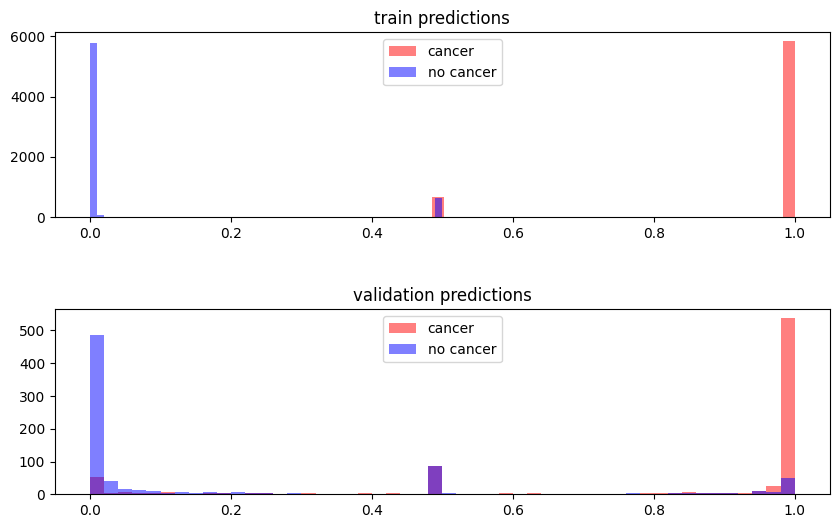

In [19]:
# put predictions through a sigmoid
t_pred_sig = F.sigmoid(train_predictions)
v_pred_sig = F.sigmoid(val_predictions)

fig, ax = plt.subplots(2, 1, figsize=(10,6))
fig.subplots_adjust(hspace=0.5)

ax[0].hist(t_pred_sig[train_labels == 1].numpy(), bins=50, color='red', alpha=0.5, label='cancer')
ax[0].hist(t_pred_sig[train_labels == 0].numpy(), bins=50, color='blue', alpha=0.5, label='no cancer')
ax[0].legend()
ax[0].set_title("train predictions")

ax[1].hist(v_pred_sig[val_labels == 1].numpy(), bins=50, color='red', alpha=0.5, label='cancer')
ax[1].hist(v_pred_sig[val_labels == 0].numpy(), bins=50, color='blue', alpha=0.5, label='no cancer')
ax[1].legend()
ax[1].set_title("validation predictions")
plt.show()